<a href="https://colab.research.google.com/github/Alfred78w/AI_project/blob/main/TP_GNN_GAT_Sourou_Alfred_SODJI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TP : Réseaux de neurones graphiques à base d'Attention.

Dans ce TP, nous nous proposons d'étudier le dataset Cora. Celui-ci est composé de 2708 papiers scientifiques répartis en sept classes. L'objectif de ce TP est de construire un modèle permettant de prédire la classe à laquelle appartient un noeud (papier scientifique).



In [1]:
import os
import torch
import networkx as nx
import pandas as pd
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

2.1.0+cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 45.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 22.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
from torch_geometric.data import Data
from torch_geometric.nn import GATConv
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import to_networkx
import torch_geometric.transforms as T


import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F

In [8]:
import numpy as np

## Analyse exploratoire du dataset Cora

On se propose ici d'explorer le dataset Cora. Il est fortement recommandé de compléter cette analyse exploratoire (visualiser le graphe, etc.).

In [18]:

dataset = Planetoid(root='~/somewhere/Cora', name='Cora')

data = dataset[0]
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Number of test nodes: {data.test_mask.sum()}')
print(f'Number of val nodes: {data.val_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Contains isolated nodes: {data.contains_isolated_nodes()}')
print(f'Contains self-loops: {data.contains_self_loops()}')

Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7
Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.90
Number of training nodes: 140
Number of test nodes: 1000
Number of val nodes: 500
Training node label rate: 0.05
Contains isolated nodes: False
Contains self-loops: False


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'contains_isolated_nodes' is deprecated, use 'has_isolated_nodes' instead
  warnings.warn(out)
/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'contains_self_loops' is deprecated, use 'has_self_loops' instead
  warnings.warn(out)


Nous pouvons voir que Cora le graphe comporte 2 708 nœuds et 10 556 arêtes, avec un degré moyen de nœud de 3,9. L'ensemble d'apprentissage n'utilise que 140 nœuds, ce qui représente 5 % de l'ensemble. . On peut également voir que ce graphe est un graphe non orienté et qu'il n'y a pas de nœuds isolés.

In [4]:
# Convertir l'indice d'arête en listes de connexions
edges = data.edge_index.numpy().T.tolist()

# Créer un graphe NetworkX à partir des informations
G = nx.Graph()
G.add_nodes_from(range(data.num_nodes))
G.add_edges_from(edges)

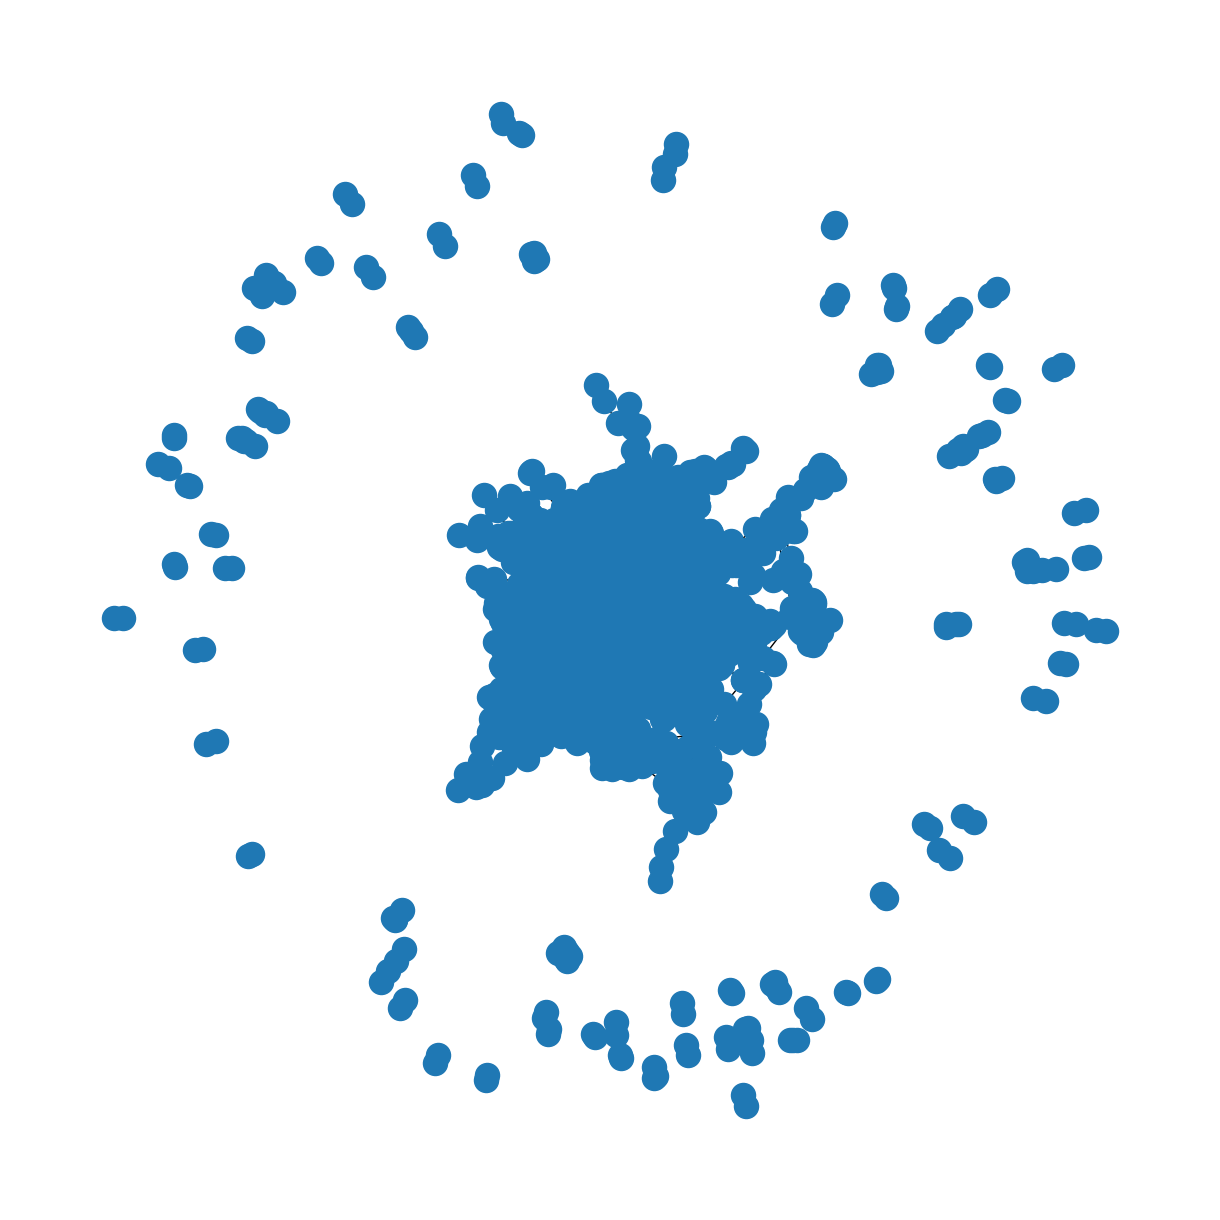

In [7]:
plt.figure(figsize=(12, 12))
nx.draw(G, with_labels = False)


**Le graph est trop large pour avoir un affichage compréhensible**

In [49]:

def plot_degree_distributions(edge_index, num_of_nodes, dataset_name):

    if isinstance(edge_index, torch.Tensor):
        edge_index = edge_index.cpu().numpy()

    assert isinstance(edge_index, np.ndarray), f'Expected NumPy array got {type(edge_index)}.'

    #Stockage du dégré de chaque noeud
    degrees = np.zeros(num_of_nodes, dtype=int)
    num_of_edges = edge_index.shape[1]
    for cnt in range(num_of_edges):
        source_node_id = edge_index[0, cnt]
        degrees[source_node_id] += 1  # le nœud source pointe vers un autre nœud -> incrémente son degré

    fig = plt.figure(figsize=(12,8))
    fig.subplots_adjust(hspace=0.6)

    plt.subplot(312)
    plt.plot(degrees, color='green')
    plt.xlabel('node id'); plt.ylabel('degree count'); plt.title('degree for different node ids')

    plt.grid(True)
    plt.show()

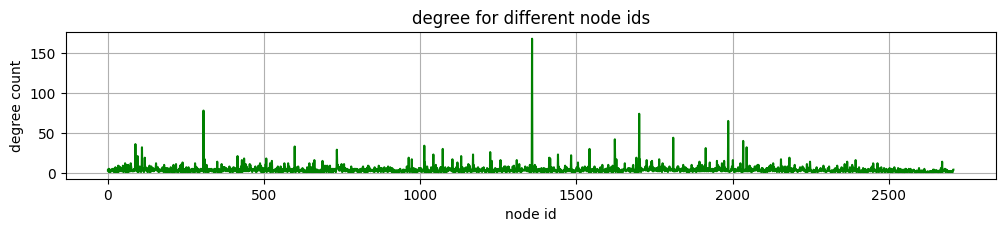

In [50]:
plot_degree_distributions(data.edge_index, data.num_nodes, data)

**Certains nœuds ont un grand nombre d'arêtes (le pic au milieu) mais la plupart des nœuds ont beaucoup moins d'arêtes.**


---


## **Question 1 : construire un modèle à base de GAT qui permet de prédire la classe à laquelle appartient un noeud.**


---





In [79]:
# Définir un modèle GAT
class GATModel(nn.Module):
    def __init__(self, in_channels, h_channels, heads, dropout):
        super(GATModel, self).__init__()
        self.conv1 = GATConv(in_channels, h_channels, heads=heads, dropout=dropout)
        self.conv2 = GATConv(h_channels * heads, dataset.num_classes, heads=1, concat=False, dropout=dropout)

    def forward(self, x, edge_index):
        x = F.dropout(x, p=0.6, training=self.training)
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)


# in_channels: Nombre de canaux en entrée, généralement le nombre de caractéristiques par nœud dans le graphe.
# h_channels: Nombre de canaux caché dans la couche de convolution GAT.
# heads: Nombre de têtes d'attention à utiliser dans la convolution GAT.
# dropout: Taux de dropout appliqué entre les couches.



# Initialisation du modèle GAT
model = GATModel(in_channels=dataset.num_features, h_channels=16, heads=8, dropout=0.6)

# Définir la fonction de perte ici entropy croisé puisqu'il s'agit d'un problème de classification multiclasse et l'optimiseur d'Adam
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

# definition de la fonction d'entrainement du modèle
def train(epoches):
    model.train()
    optimizer.zero_grad()
    output = model(data.x, data.edge_index)
    loss = criterion(output[data.train_mask], data.y[data.train_mask])
    #Utilisation de la retropropagation
    loss.backward()
    optimizer.step()
    # Measure accuracy on training set
    pred = output.argmax(dim=1)
    acc = pred[data.train_mask].eq(data.y[data.train_mask]).sum().item() / data.train_mask.sum().item()

    return loss, acc

# Tester le modèle
def validate():
    model.eval()
    output = model(data.x, data.edge_index)
    pred = output.argmax(dim=1)
    acc = pred[data.val_mask].eq(data.y[data.val_mask]).sum().item() / data.val_mask.sum().item()
    return acc

train_acc_list = []
val_acc_list = []

# Boucle d'entraînement
for epoch in range(200):
    train_loss, train_acc = train(epoch)
    val_acc = validate()

    # Ajout des valeurs à la liste
    train_acc_list.append(train_acc)
    val_acc_list.append(val_acc)

    print(f'Epoch: {epoch:03d}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}, Validation Accuracy: {val_acc:.4f}')

Epoch: 000, Train Loss: 1.9564, Train Accuracy: 0.1500, Validation Accuracy: 0.4980
Epoch: 001, Train Loss: 1.8805, Train Accuracy: 0.3286, Validation Accuracy: 0.6640
Epoch: 002, Train Loss: 1.7023, Train Accuracy: 0.4786, Validation Accuracy: 0.7640
Epoch: 003, Train Loss: 1.6016, Train Accuracy: 0.5357, Validation Accuracy: 0.7800
Epoch: 004, Train Loss: 1.4986, Train Accuracy: 0.6714, Validation Accuracy: 0.7960
Epoch: 005, Train Loss: 1.4356, Train Accuracy: 0.6571, Validation Accuracy: 0.8040
Epoch: 006, Train Loss: 1.2990, Train Accuracy: 0.6357, Validation Accuracy: 0.7920
Epoch: 007, Train Loss: 1.1938, Train Accuracy: 0.6571, Validation Accuracy: 0.7820
Epoch: 008, Train Loss: 1.0746, Train Accuracy: 0.7214, Validation Accuracy: 0.7720
Epoch: 009, Train Loss: 1.1239, Train Accuracy: 0.6429, Validation Accuracy: 0.7660
Epoch: 010, Train Loss: 0.9007, Train Accuracy: 0.7429, Validation Accuracy: 0.7700
Epoch: 011, Train Loss: 0.9219, Train Accuracy: 0.7500, Validation Accuracy:

Les hyperparamètres ont été choisi après des tests sur plusieurs hyperparamètres

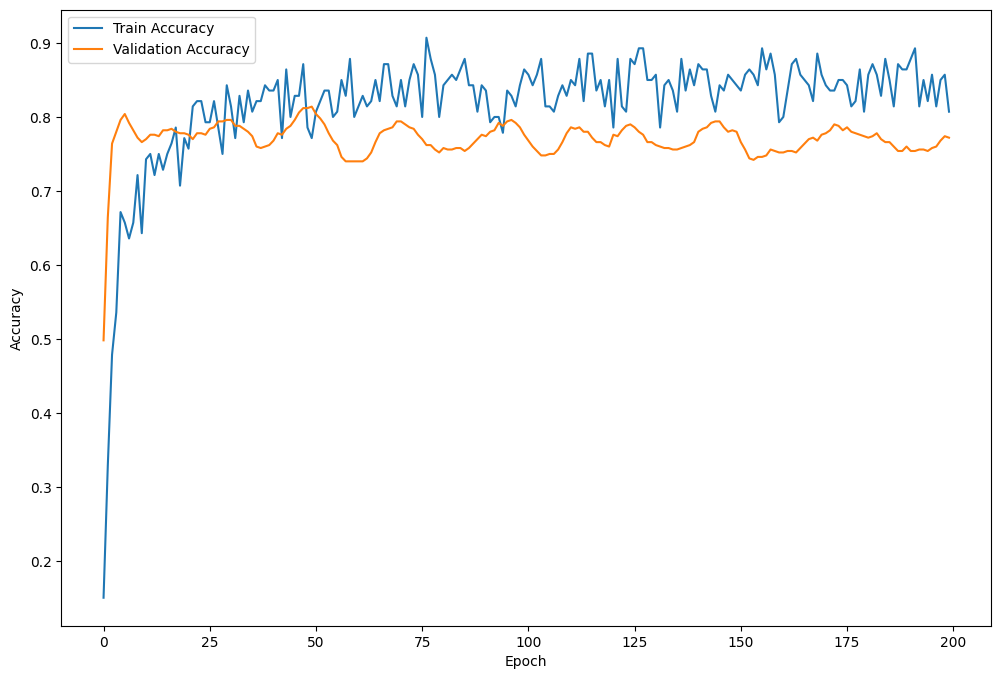

In [80]:
import matplotlib.pyplot as plt

# Afficher le graphique
epochs = range(200)
fig = plt.figure(figsize=(12,8))
plt.plot(epochs, train_acc_list, label='Train Accuracy')
plt.plot(epochs, val_acc_list, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


**La courbe montre qu'il n'y pas de risque de surapprentissation ni de sous-apprentissage. Donc nous pouvons passer au test de notre modèle**

In [81]:
# Évaluer le modèle sur l'ensemble de test
def test():
  model.eval()
  with torch.no_grad():
      pred_test = model(data.x, data.edge_index)
      test_acc = pred_test[data.test_mask].argmax(dim=1).eq(data.y[data.test_mask]).sum().item() / data.test_mask.sum().item()
      return test_acc
print(f'Test Accuracy: {test():.4f}')

Test Accuracy: 0.8010


**Nous avons une précision de 80%. Appréciable!**


---

